## Bayesian Hyperparameter Tuning for Multi-class Prediction 
* Predict 7 levels from underweight to obese for the obesity data on Kaggle
* Models: LightGBM
  * Hyperparameters found using Bayesian Optimization 
* Prediction is to improve test accuracy

### Import modules

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import yaml

from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

### Settings

In [2]:
with open('../config.yml', 'r') as file:
    settings = yaml.safe_load(file)

### Data

In [3]:
train_df = pd.read_csv(Path('../' + settings['data']['train']), sep=',')

In [54]:
test_df = pd.read_csv(Path('../' + settings['data']['test']), sep=',')

### Functions

In [68]:
def plot_data_overview(df: pd.DataFrame) -> None:
    """
    This function creates a box plot for numeric variables and a bar plot with distribution for categorical variables.

    Parameters:
    df  The input dataframe containing numeric and categorical variables.

    Returns:
    None: Displays the plots.
    """
    numeric_vars = df.select_dtypes(include=['number']).columns
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    
    # Plotting box plots for numeric variables
    for var in numeric_vars:
        plt.figure(figsize=(10, 6))
        sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":8})
        sns.boxplot(data=df, y=var)
        plt.title(f'Box Plot for {var}')
        plt.show()

    # Plotting bar plots for categorical variables
    for var in categorical_vars:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=var)
        plt.title(f'Distribution of {var}')
        plt.show()

In [69]:
def plot_data_by_predictor(df: pd.DataFrame, predictor: str) -> None:
    """
    This function creates a box plot for numeric variables and a bar plot for categorical variables, 
    split by the predictor class.

    Parameters:
    df: The input dataframe containing numeric and categorical variables.
    predictor: The name of the predictor column.

    Returns:
    None: Displays the plots.
    """
    numeric_vars = df.select_dtypes(include=['number']).columns
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    # Remove the predictor from categorical variables
    if categorical_vars[-1] == predictor:
        categorical_vars = categorical_vars[:-1]
    
    # Plotting box plots for numeric variables split by predictor
    for var in numeric_vars:
        plt.figure(figsize=(10, 6))
        sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":8})
        sns.boxplot(data=df, x=predictor, y=var)
        plt.title(f'Box Plot for {var} by {predictor}')
        plt.show()

    # Plotting bar plots for categorical variables split by predictor
    for var in categorical_vars:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=var, hue=predictor)
        plt.title(f'Distribution of {var} by {predictor}')
        plt.show()

In [60]:
def plot_histograms(df: pd.DataFrame, bins: int=5):
    """
    This function creates histograms for numeric variables in the dataframe.

    Parameters:
    df: The input dataframe containing numeric variables.
    bins: The number of bins to use for the histograms (default is 10).

    Returns:
    None: Displays the histograms.
    """
    numeric_vars = df.select_dtypes(include=['number']).columns
    
    for var in numeric_vars:
        plt.figure(figsize=(10, 6))
        plt.hist(df[var], bins=bins, edgecolor='black')
        plt.title(f'Histogram of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.show()

In [5]:
def encode_input_features(df: pd.DataFrame, ordinal_cols: dict=None, one_hot_cols: list=None) -> pd.DataFrame:
    """
    Encode categorical variables in a DataFrame using Ordinal Encoding and One-Hot Encoding.

    Parameters:
    df: The input DataFrame.
    ordinal_cols: A dictionary where keys are column names to apply ordinal encoding to, and values are lists specifying the order of categories.
    one_hot_cols: A list of column names to apply one-hot encoding to.

    Returns:
    The DataFrame with encoded variables.
    """
    df_encoded = df.copy()
    
    # Ordinal Encoding
    if ordinal_cols:
        for col, categories in ordinal_cols.items():
            ordinal_encoder = OrdinalEncoder(categories=[categories])
            df_encoded[col] = ordinal_encoder.fit_transform(df_encoded[[col]])
    
    # One-Hot Encoding
    if one_hot_cols:
        one_hot_encoder = OneHotEncoder(sparse_output=False, drop=None)
        one_hot_encoded = one_hot_encoder.fit_transform(df_encoded[one_hot_cols])
        one_hot_df = pd.DataFrame(one_hot_encoded, 
                                  columns=one_hot_encoder.get_feature_names_out(one_hot_cols))
        df_encoded = pd.concat([df_encoded.drop(columns=one_hot_cols), one_hot_df], axis=1)

    return df_encoded

In [6]:
def label_encode(target_data: pd.Series) -> [np.ndarray, LabelEncoder]:
    """
    Label encode target column

    Parameters:
    target_data: Target data to predict

    Returns:
    Encoded target data and fit label encoder that is needed to reverse the encoding
    """
    label_encoder = LabelEncoder()
    target_encoded = label_encoder.fit_transform(target_data)

    return target_encoded, label_encoder

In [7]:
def plot_confusionmatrix(y_pred: np.ndarray, y_actual: np.ndarray, class_labels: list) -> None:
    """
    Plot confusion matrix for predicted and actual classes

    Parameters:
    y_pred: Predicted targets
    y_actual: True targets
    class_labels: Labels for the target classes

    Return:
    None: Plots a confusion matrix
    """
    
    cf = confusion_matrix(y_pred, y_actual)
    sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":8})
    sns.heatmap(cf, annot=True, yticklabels=class_labels, xticklabels=class_labels, cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

In [37]:
def evaluate_model(model: ClassifierMixin, X_test: pd.DataFrame, y_test: np.ndarray, class_labels: list=None, is_ligthgbm: bool=False) -> dict:
    """
    Evaluate a trained model on a test set by plotting confusion matrix and generating the accuracy and F1 score.

    Parameters:
    model: The trained model to evaluate
    X_test: The test features
    y_test: The true labels for the test set
    class_labels: Labels for the target classes
    is_lightgbm: Boolean to check if the model is a LightGBM type

    Returns:
    A dictionary containing the accuracy and F1 score.
    """
    
    # Predict the labels for the test set
    if is_ligthgbm:
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = model.predict(X_test)

    # Confusion matrix
    if class_labels:
        plot_confusionmatrix(y_pred, y_test, class_labels)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='micro')
    
    # Return the results as a dictionary
    return {
        'accuracy': accuracy,
        'f1_score': f1
    }

In [52]:
def save_test_prediction_result(
    model: ClassifierMixin, 
    test_df: pd.DataFrame, 
    ordinal_cols: dict, 
    one_hot_cols: list, 
    target_column: str, 
    label_encoder: LabelEncoder,
    is_ligthgbm: bool=False
) -> None:
    """
    Predict on test data set and save results in a csv

    Parameters:
    model: Trained model
    test_df: Dataframe with test data
    ordinal_cols: Dictionary with mapping columns and categories for ordinal encoding
    one_hot_cols: List of columns for one-hot encoding
    target_column: Target feature name
    label_encoder: Fit label encoder for reversing the encoding
    is_lightgbm: Boolean to check if the model is a LightGBM type
    
    Returns:
    None: saves the results
    """
    # Create output dataframe with ID
    test_predict_results = test_df['id'].to_frame()
    del test_df['id']
    
    # Predict on test data
    X_test_enc = encode_input_features(test_df, ordinal_cols, one_hot_cols)
    if is_ligthgbm:
        test_pred = model.predict(X_test_enc, num_iteration=model.best_iteration)
        test_pred = np.argmax(test_pred, axis=1)
    else:
        test_pred = model.predict(X_test_enc)
    test_predict_results[target_column] = label_encoder.inverse_transform(test_pred)
    
    # Save output
    test_predict_results.to_csv(Path('../data/output/' + 'test_predictions.csv'), index=False)

### Exploratory analysis

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [76]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

In [6]:
# Remove 'id'
del train_df['id']
del test_df['id']

In [7]:
# Order predictor variable
train_df['NObeyesdad'] = pd.Categorical(
    train_df['NObeyesdad'], 
    categories=["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"],
    ordered=True
)

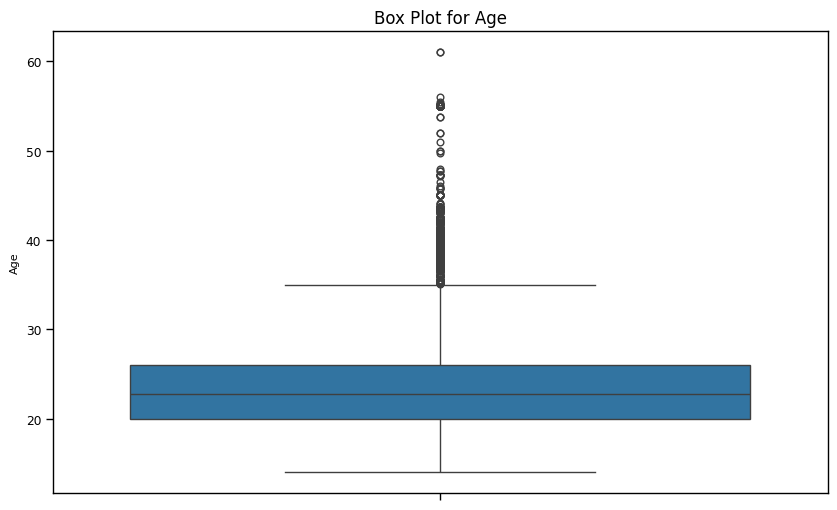

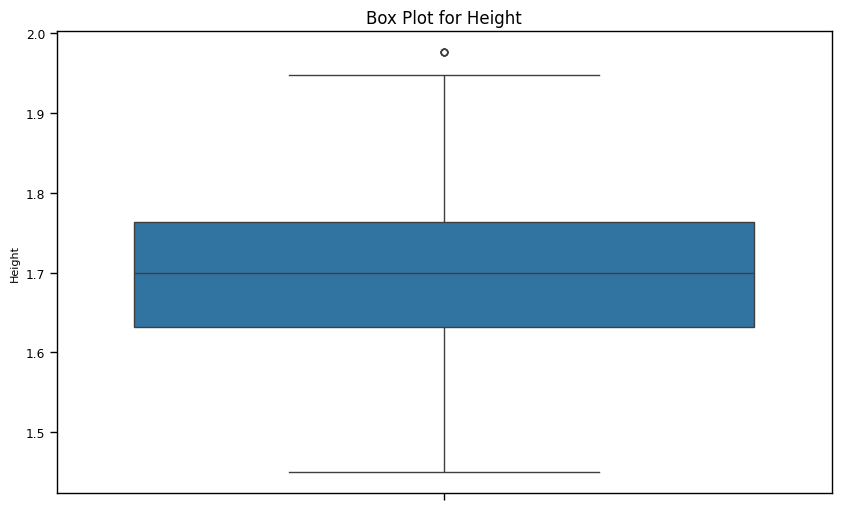

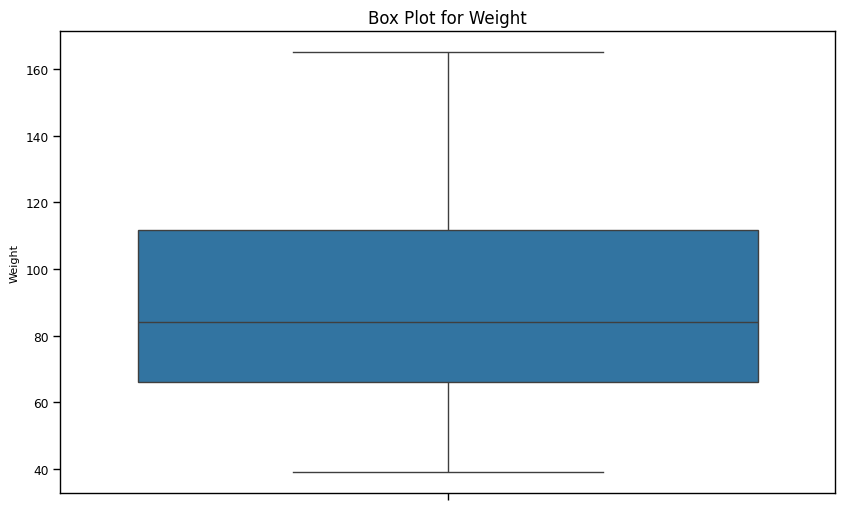

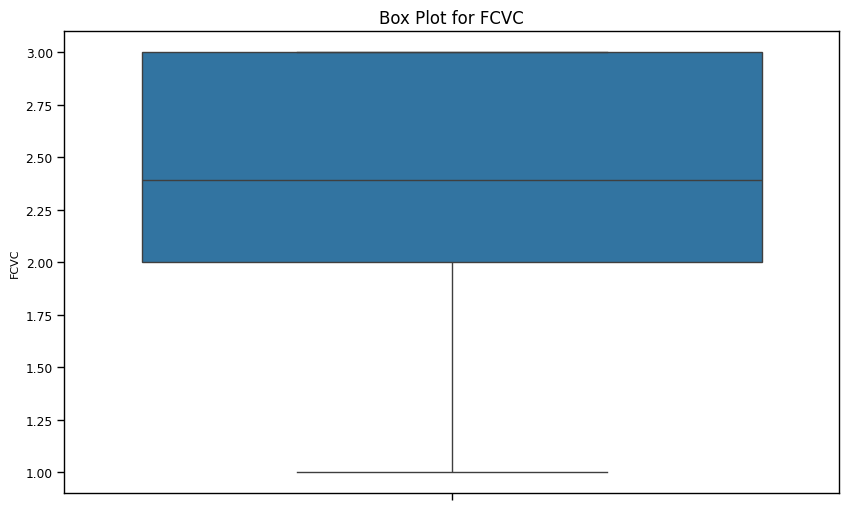

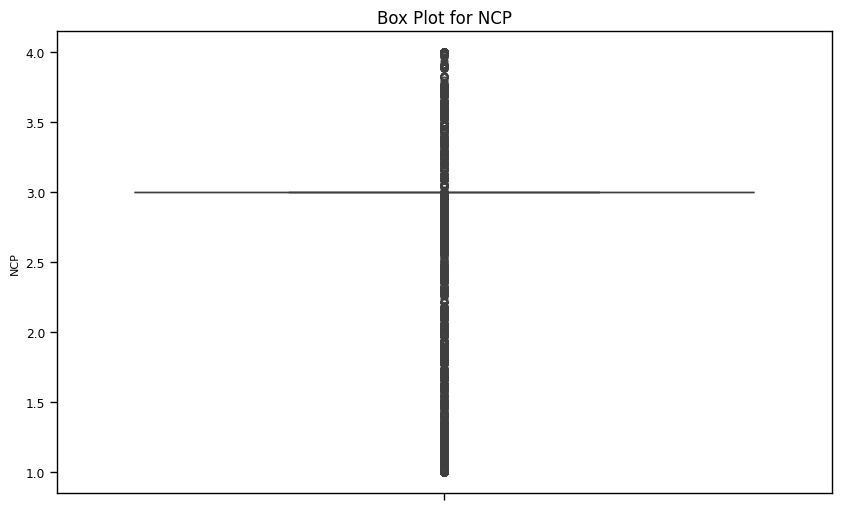

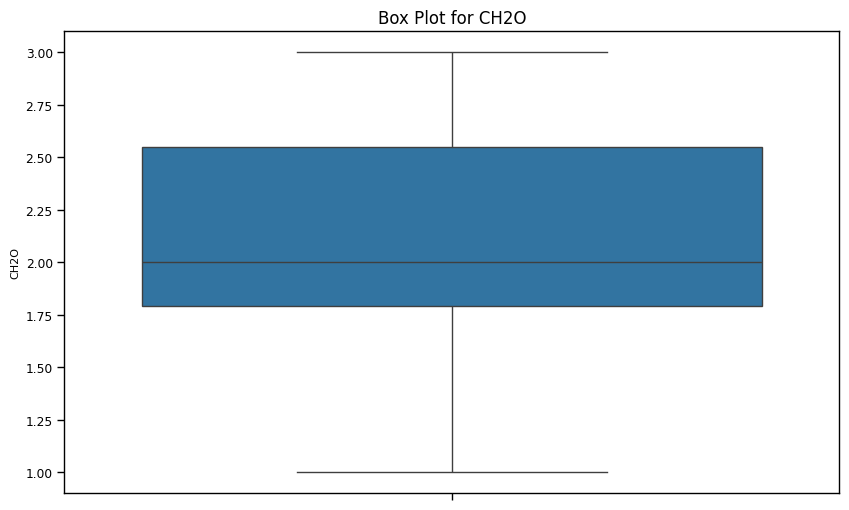

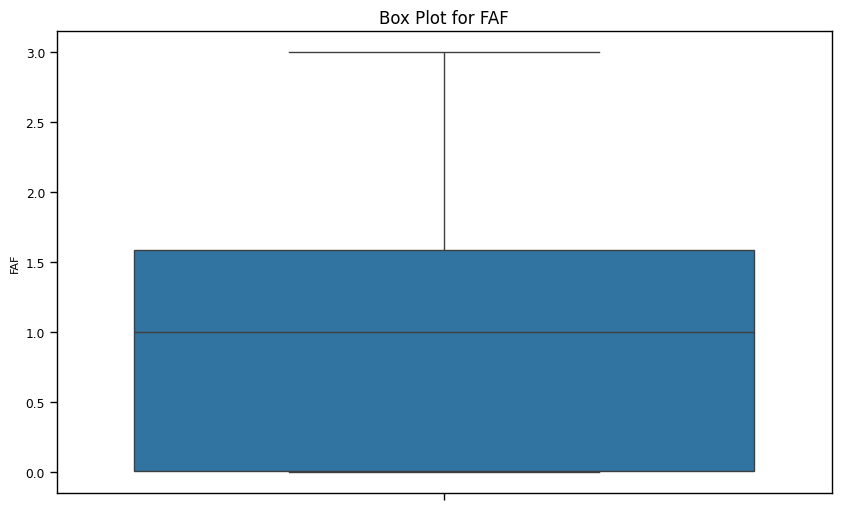

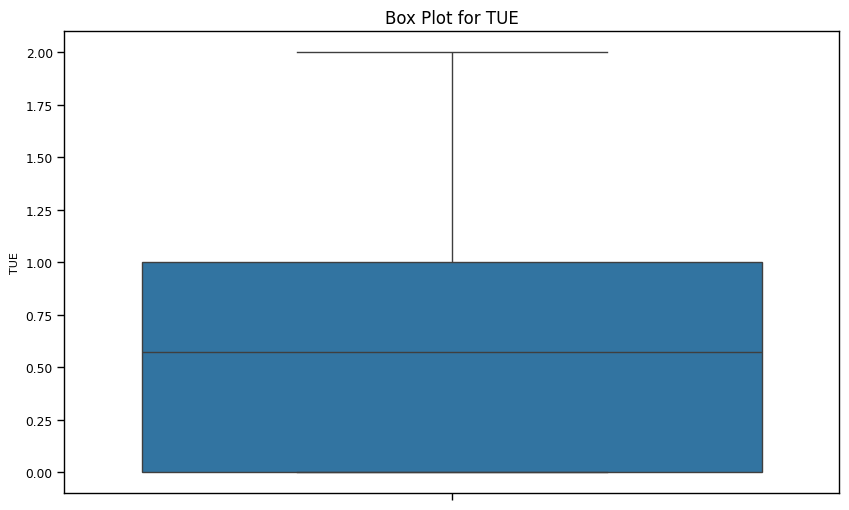

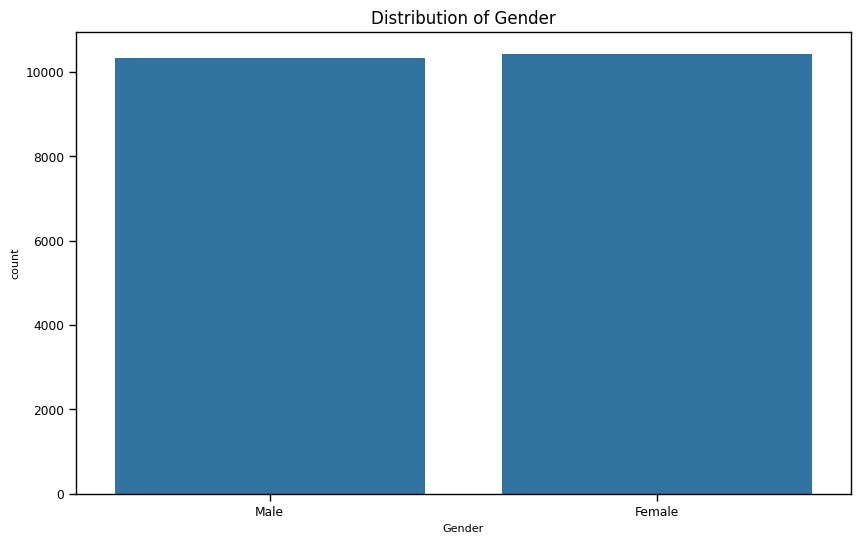

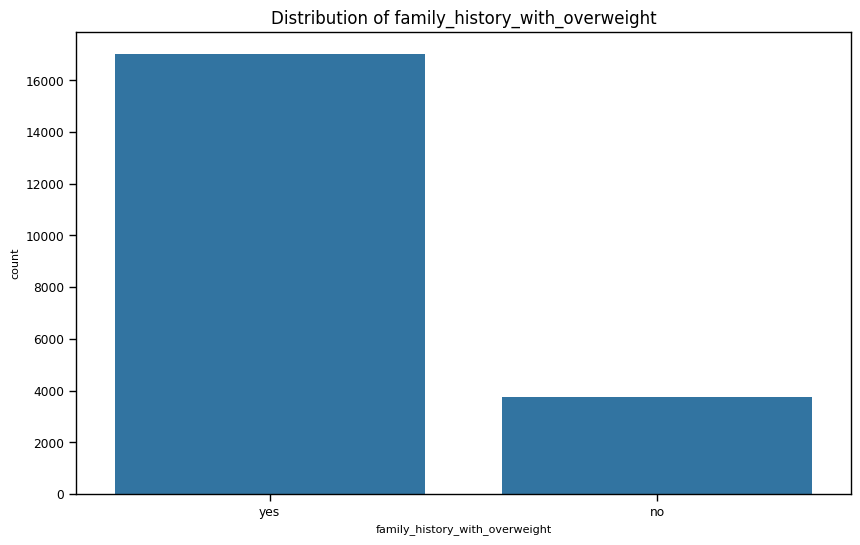

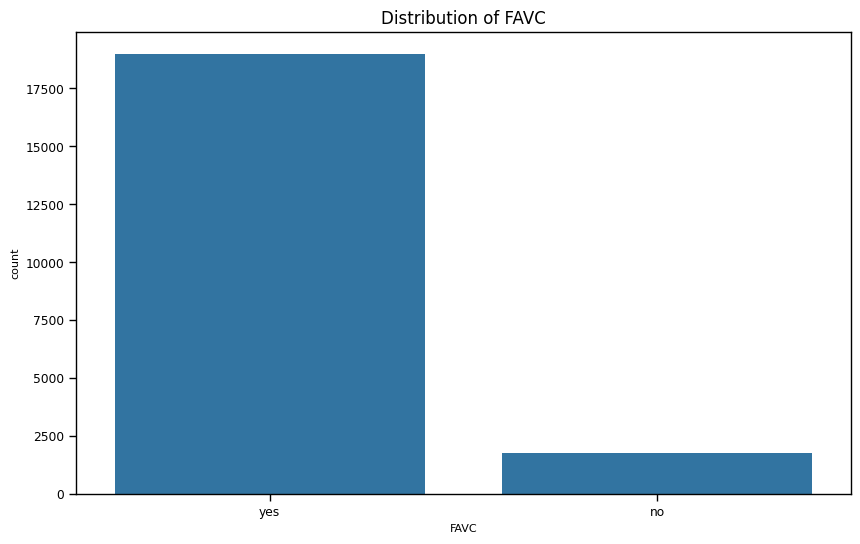

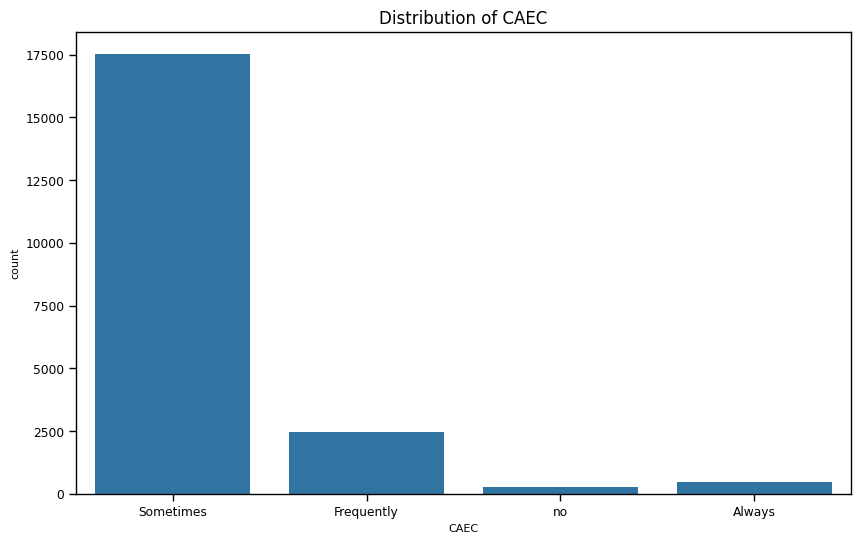

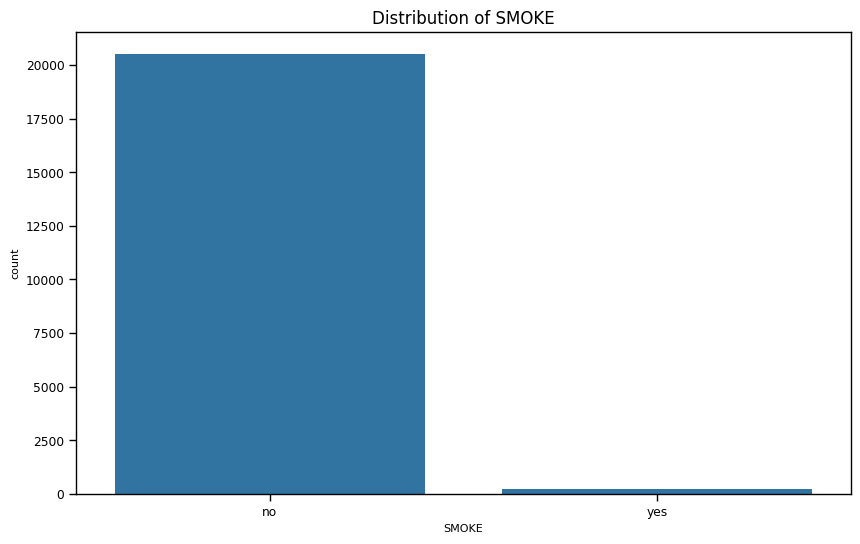

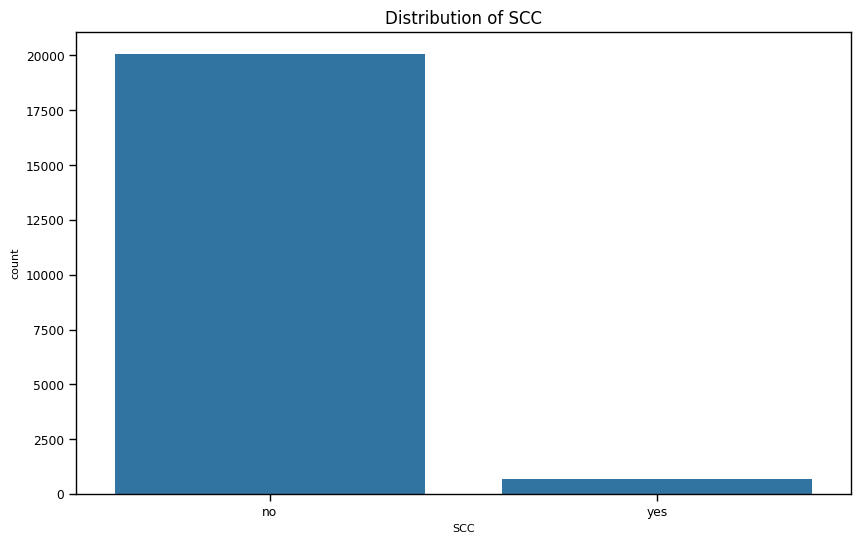

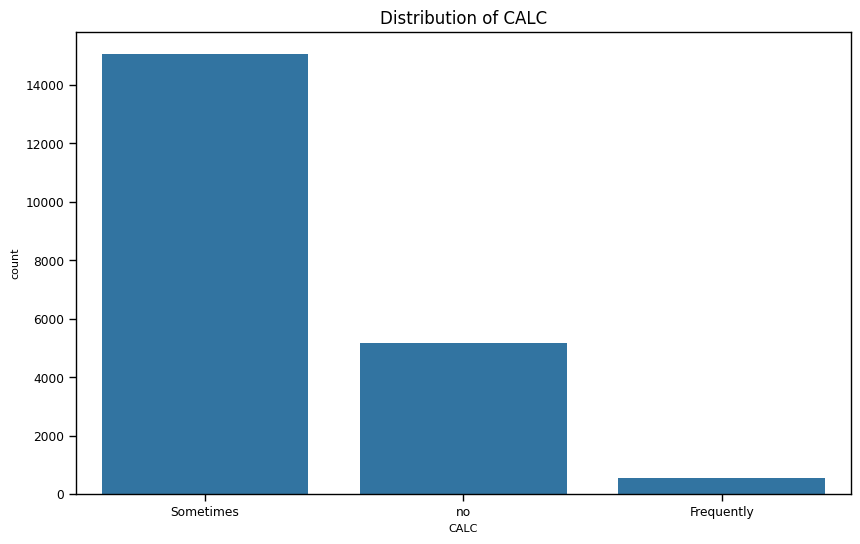

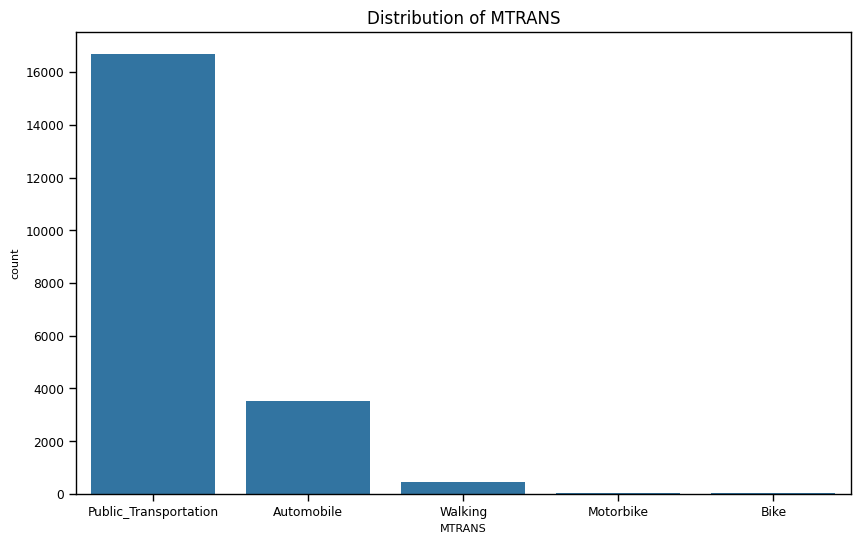

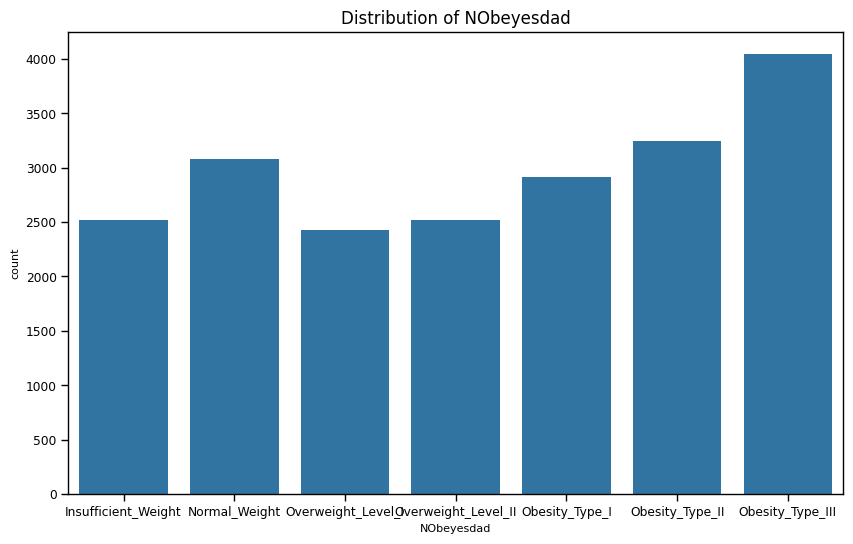

In [70]:
plot_data_overview(train_df)

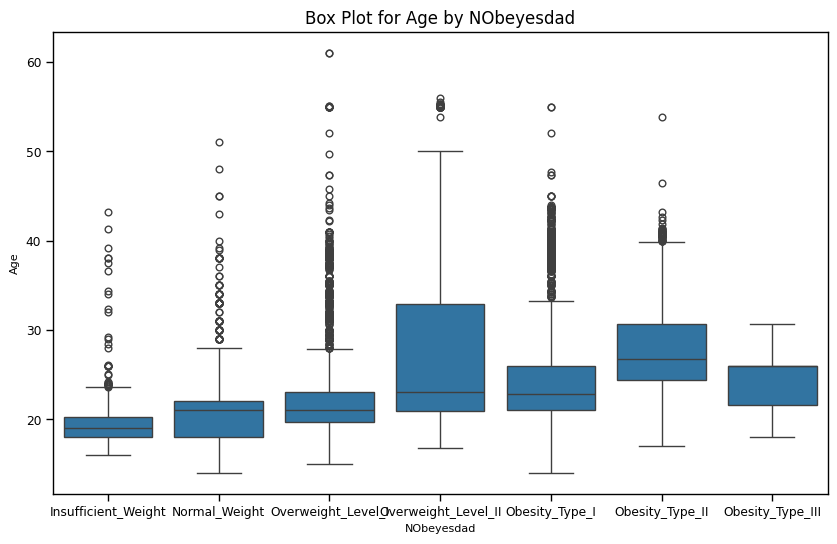

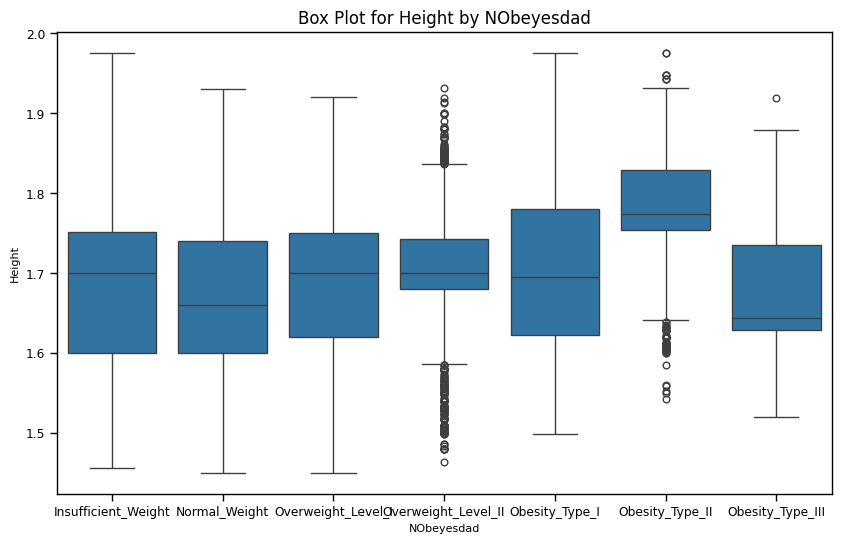

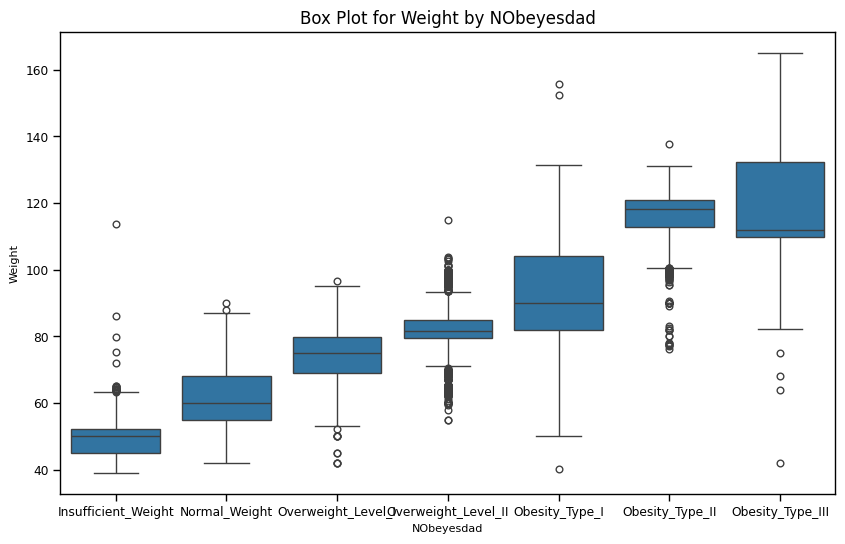

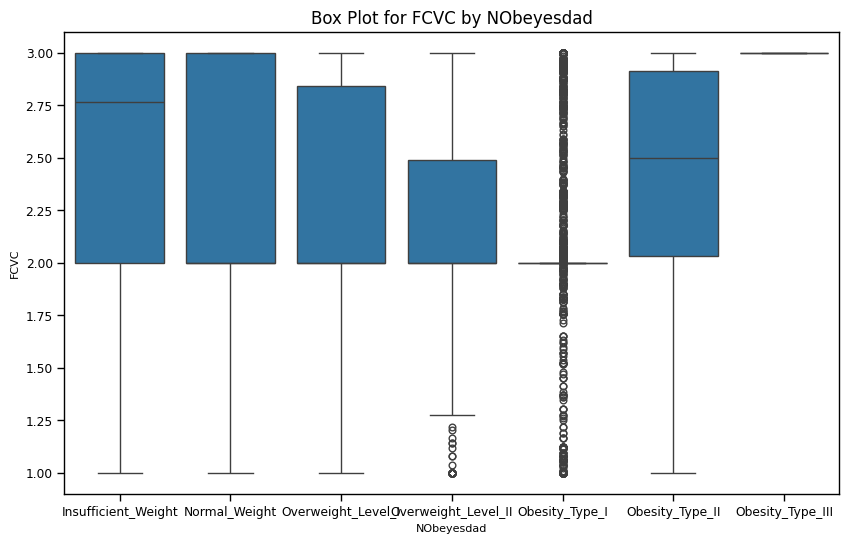

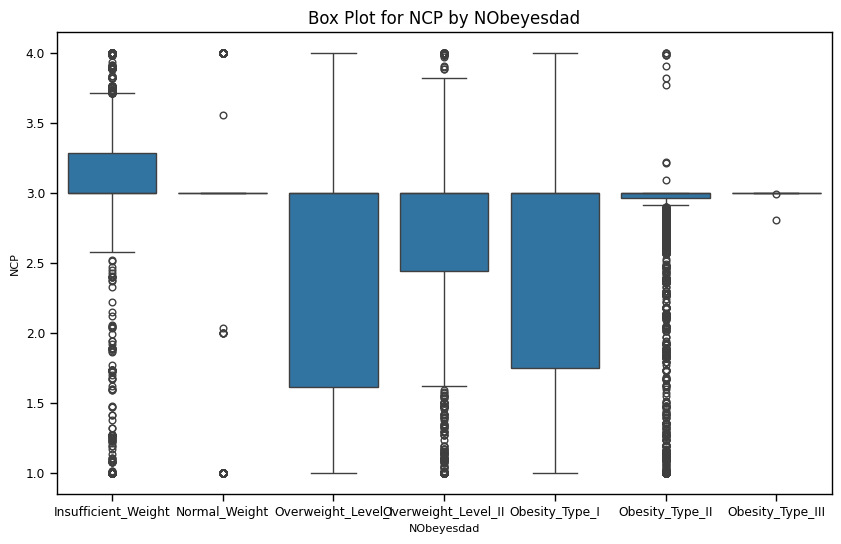

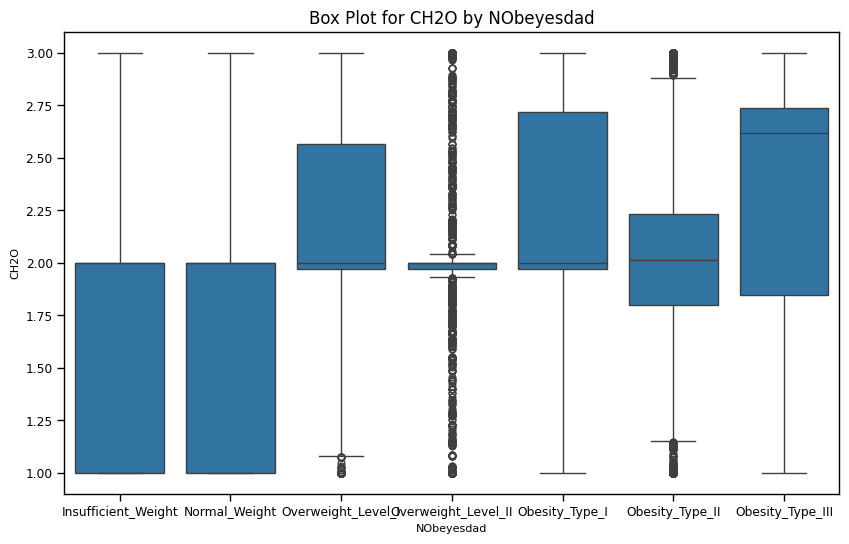

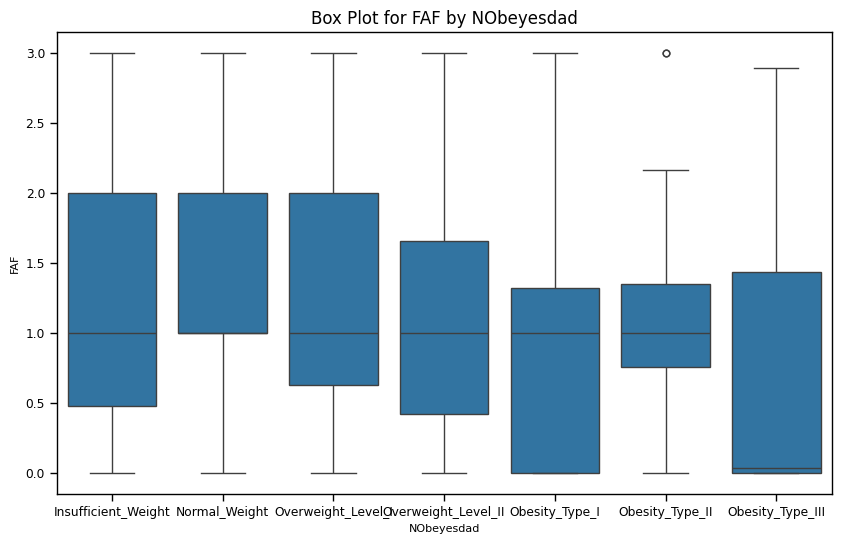

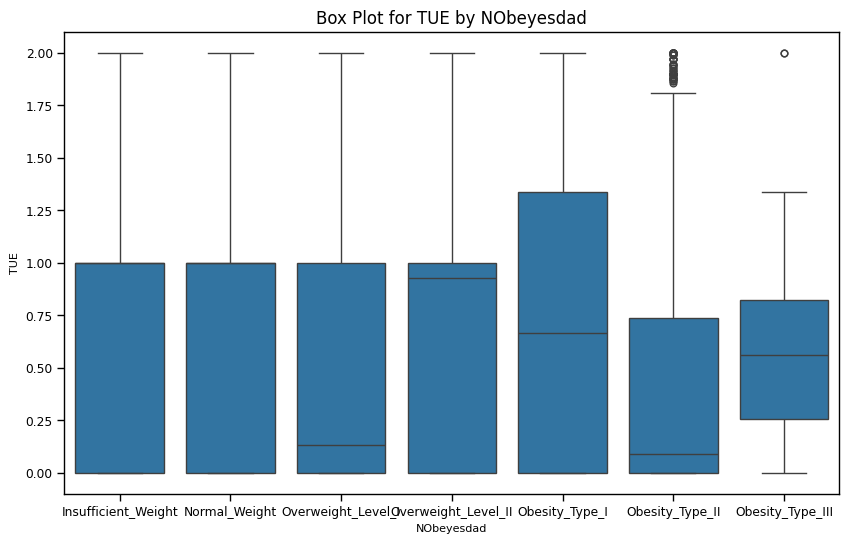

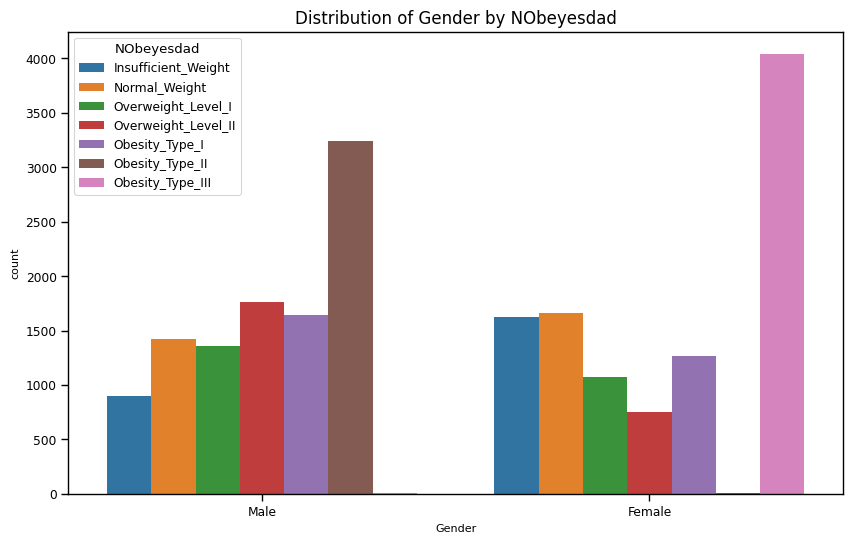

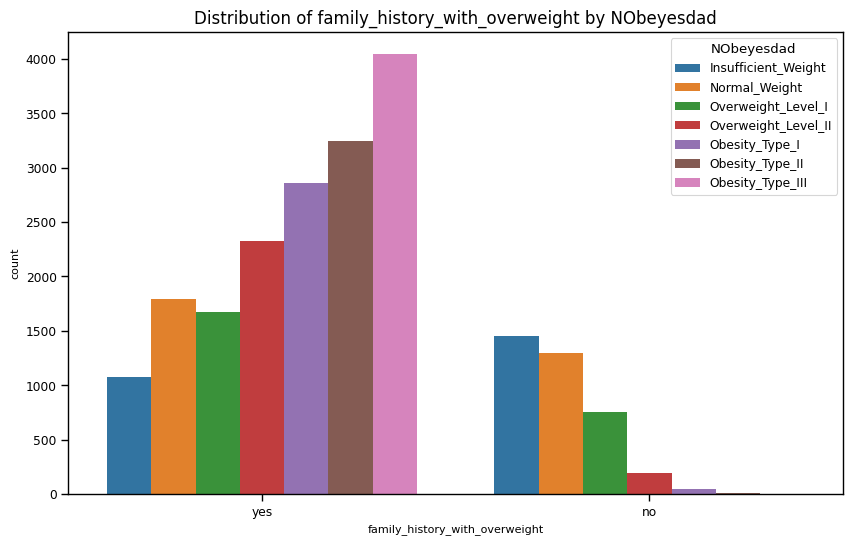

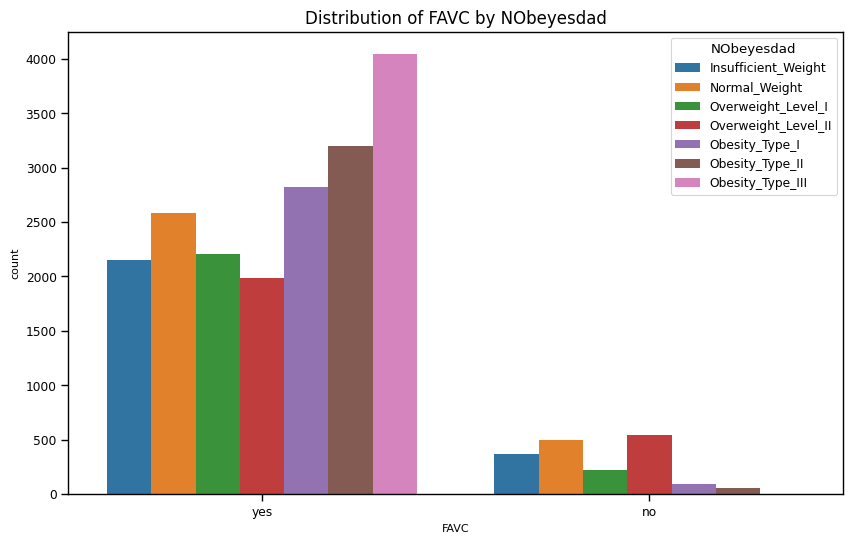

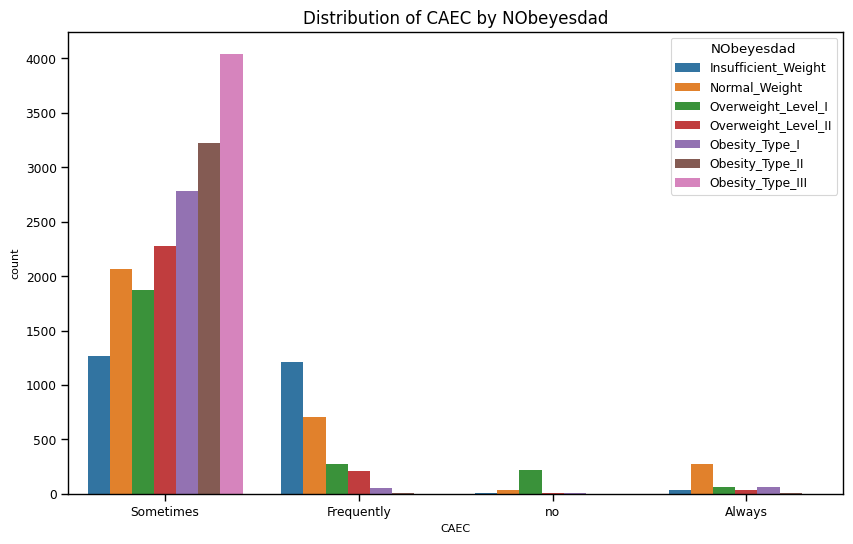

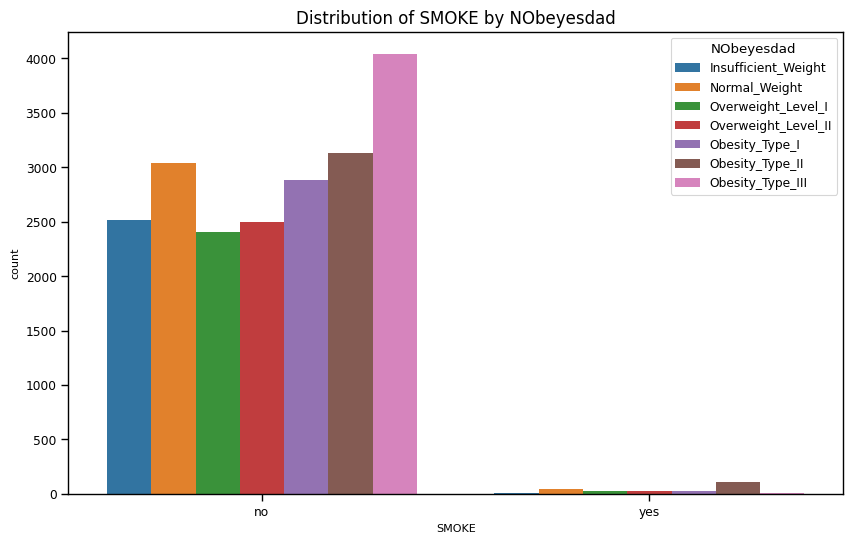

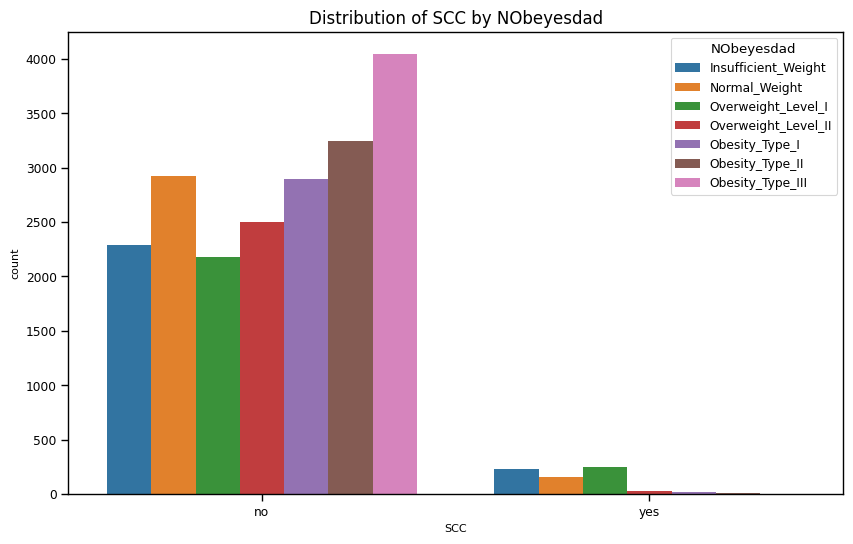

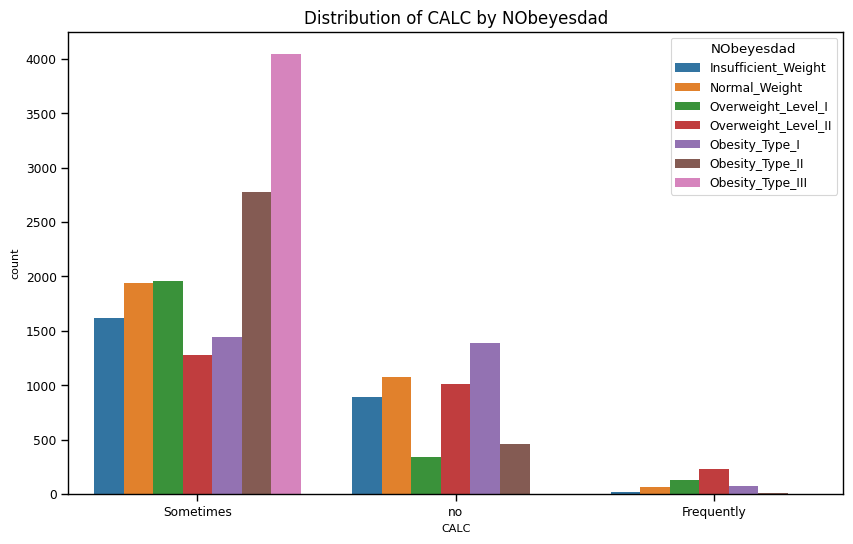

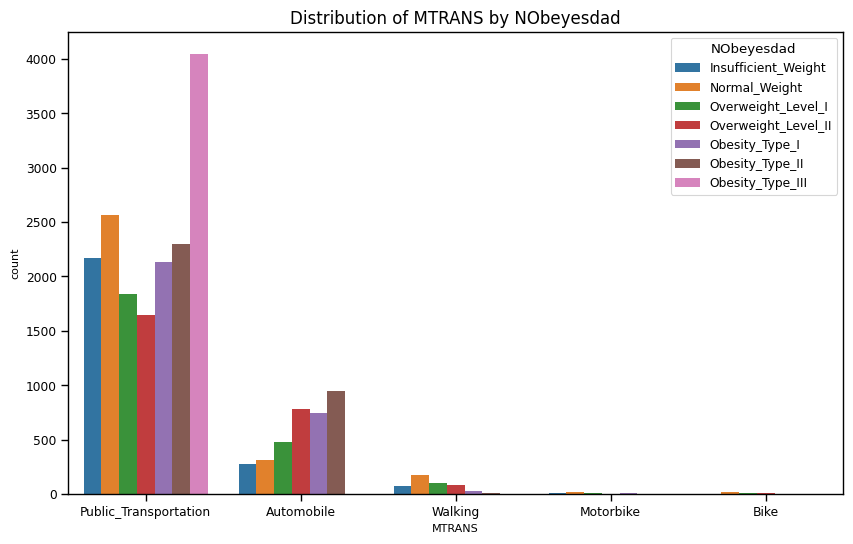

In [71]:
plot_data_by_predictor(train_df, 'NObeyesdad')

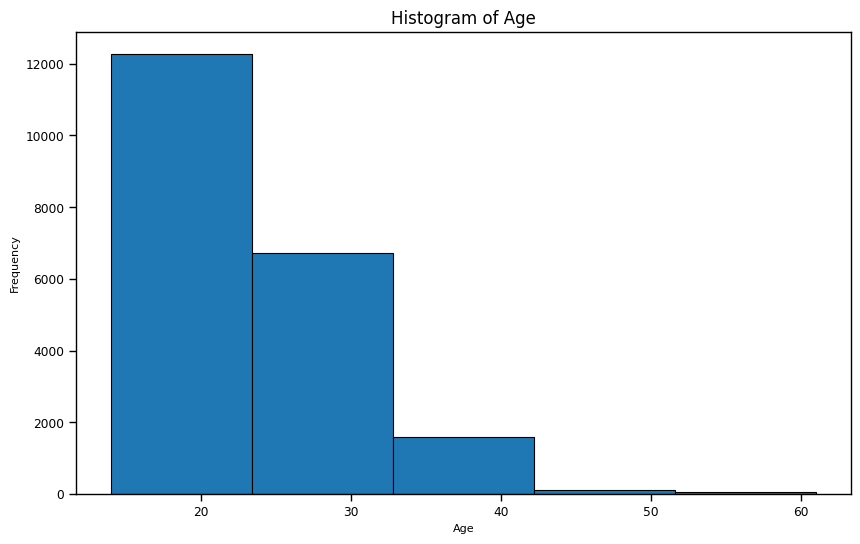

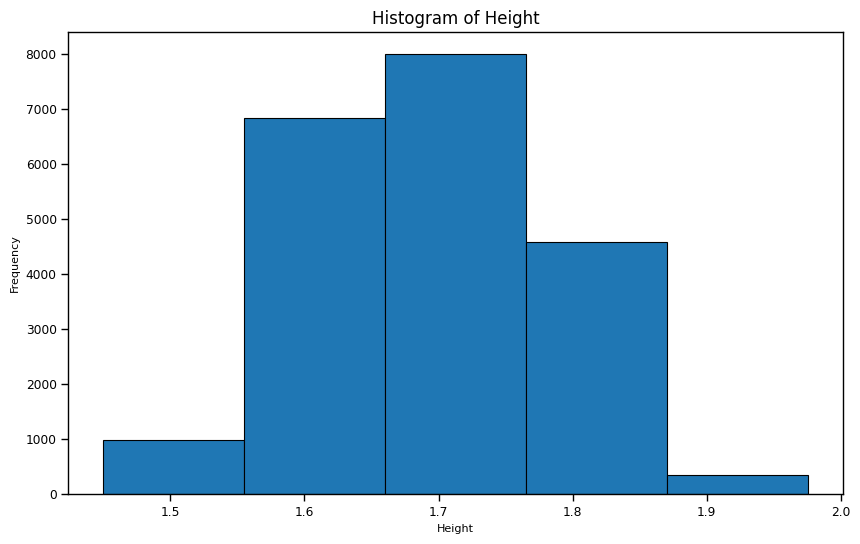

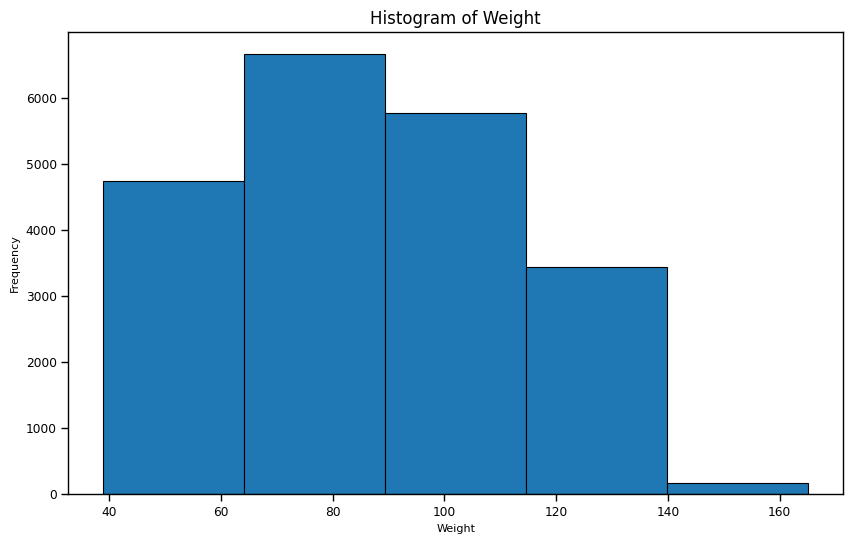

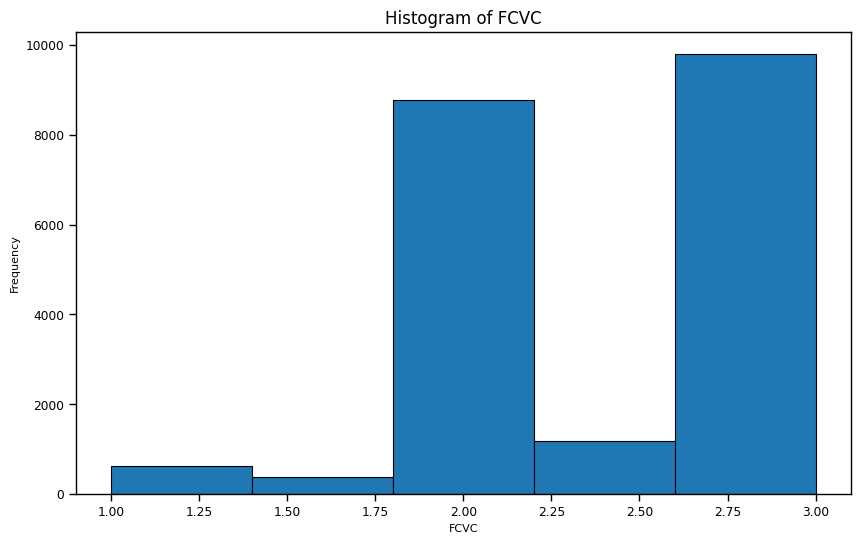

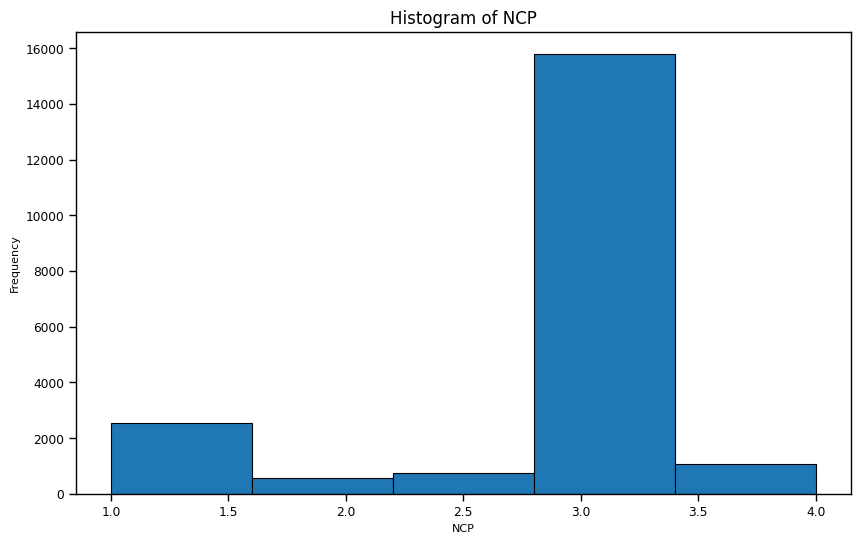

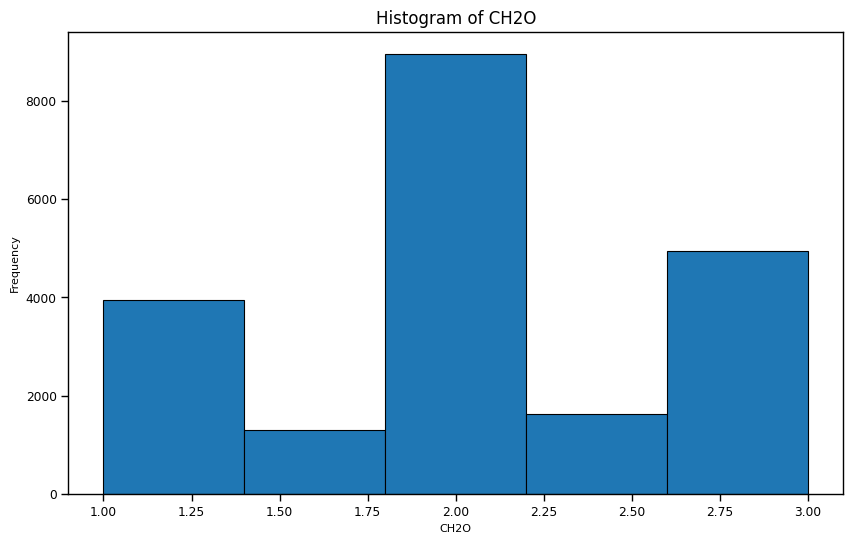

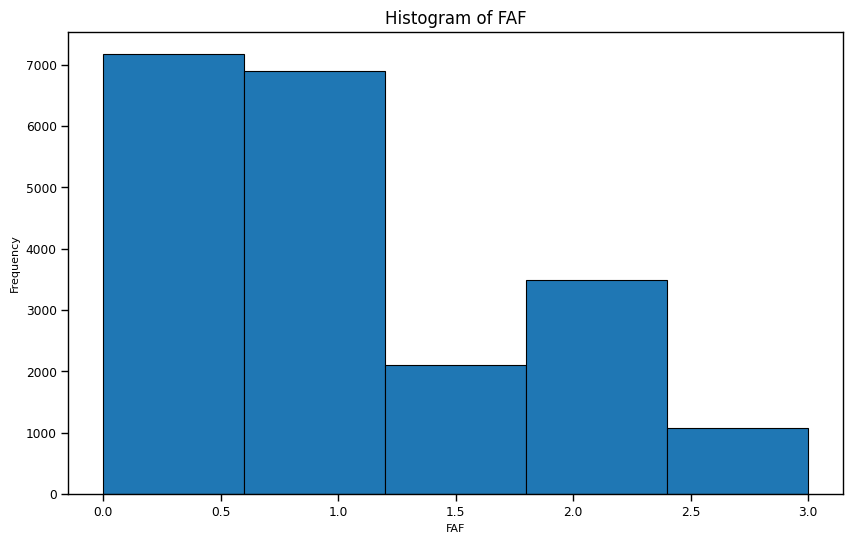

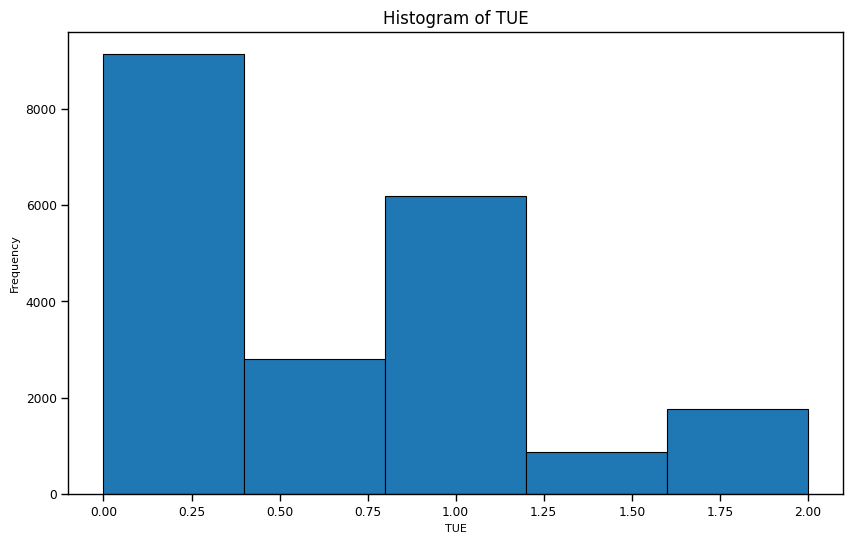

In [72]:
plot_histograms(train_df)

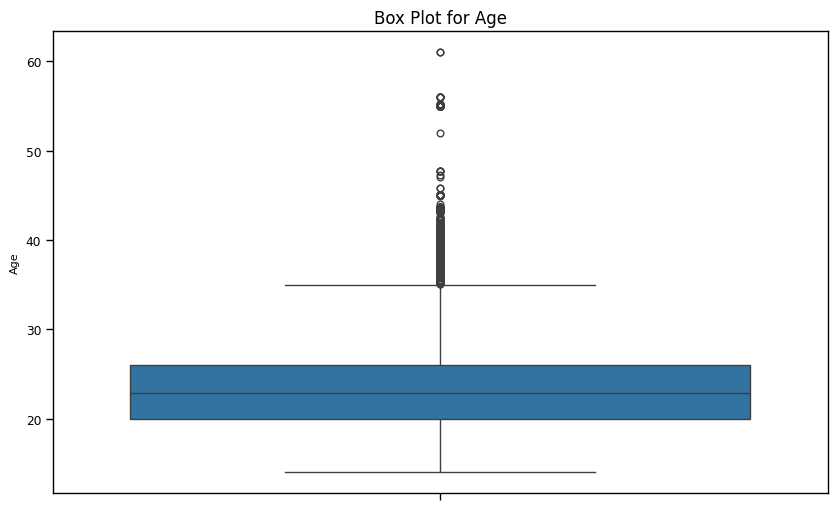

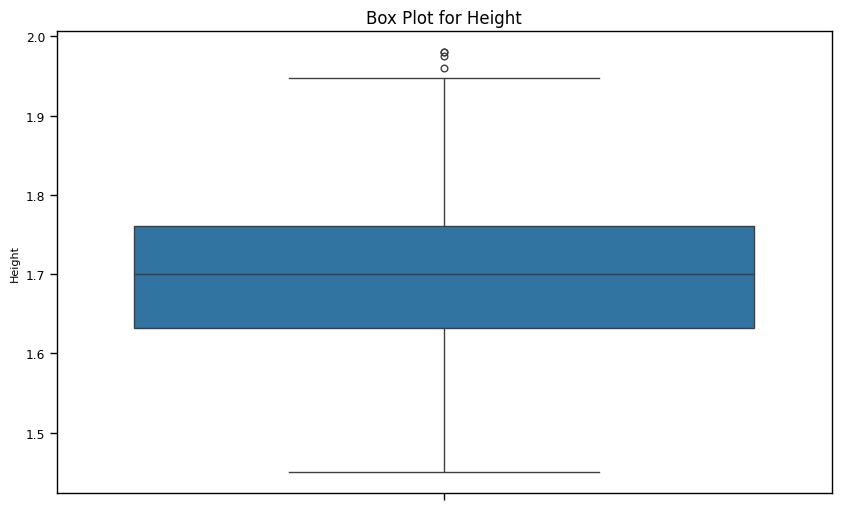

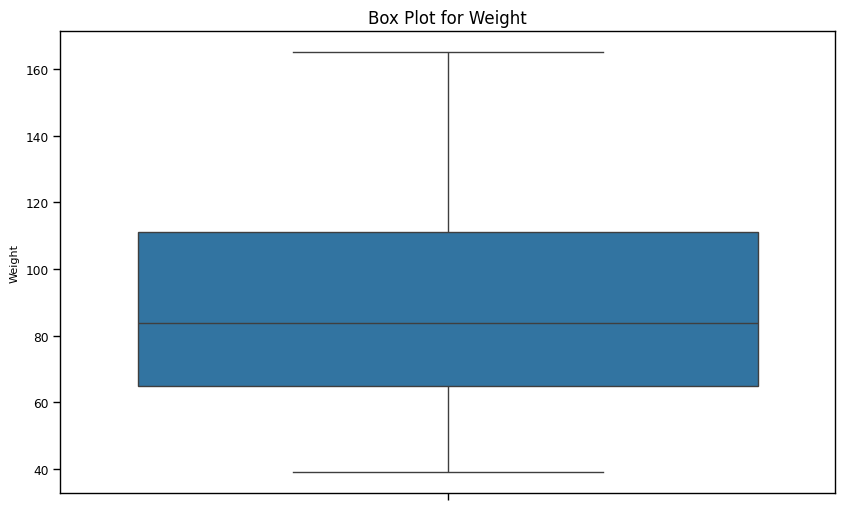

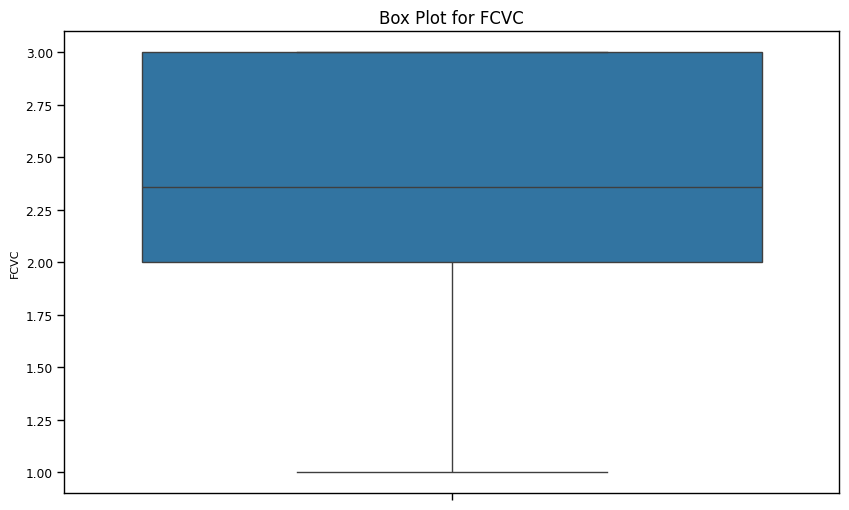

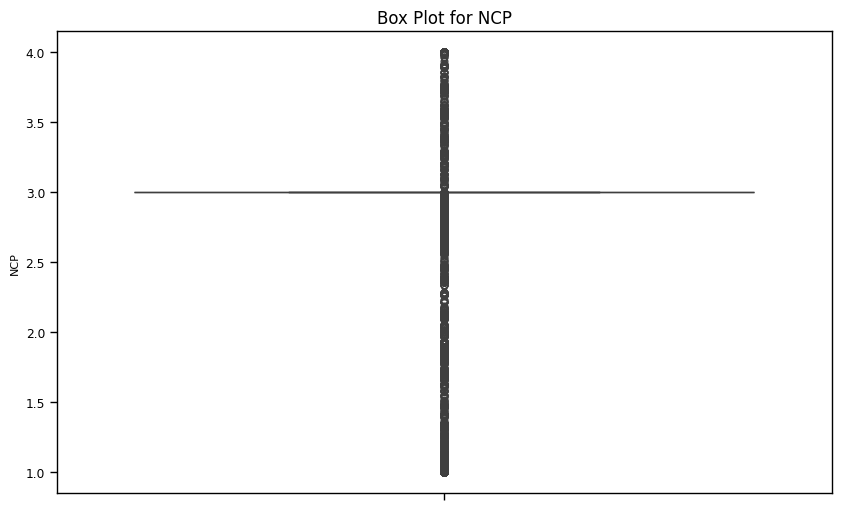

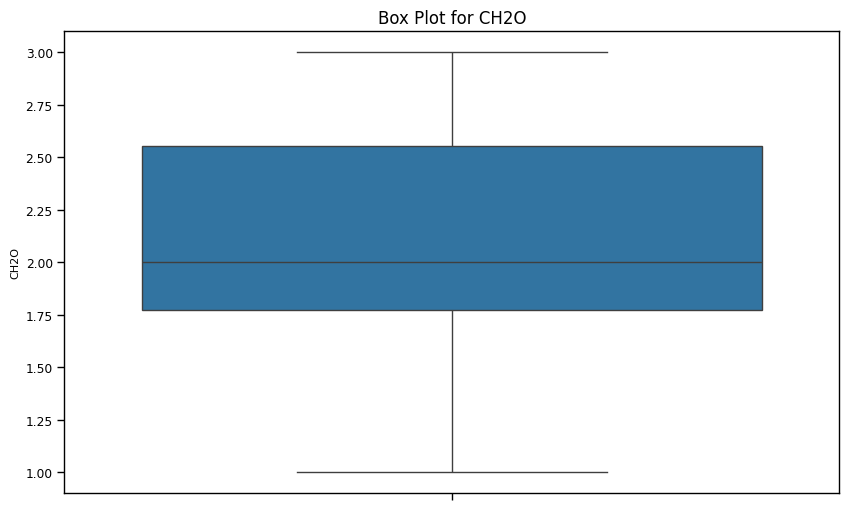

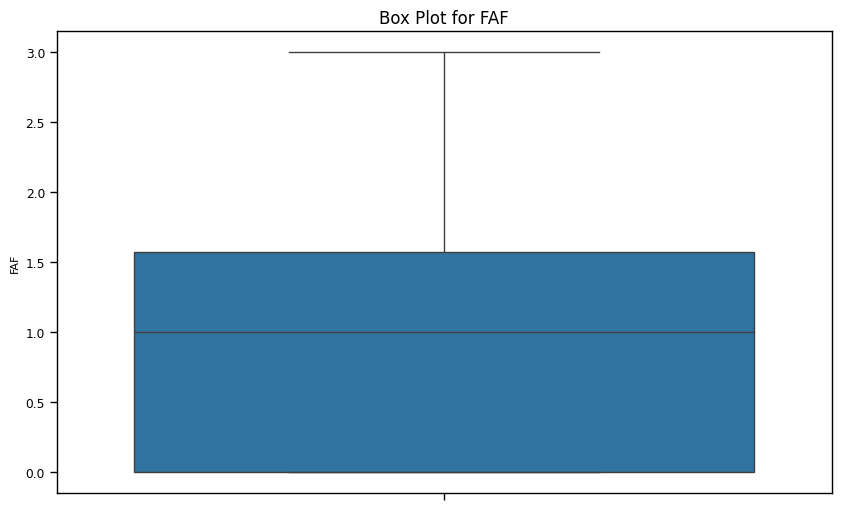

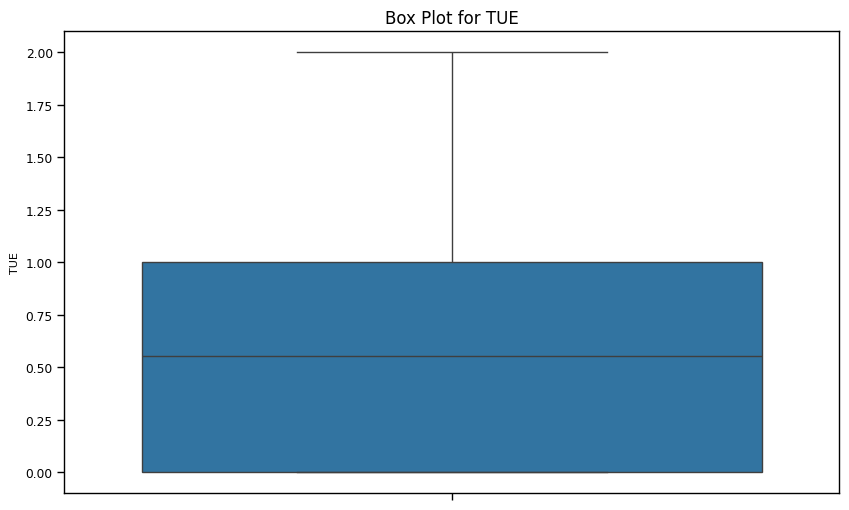

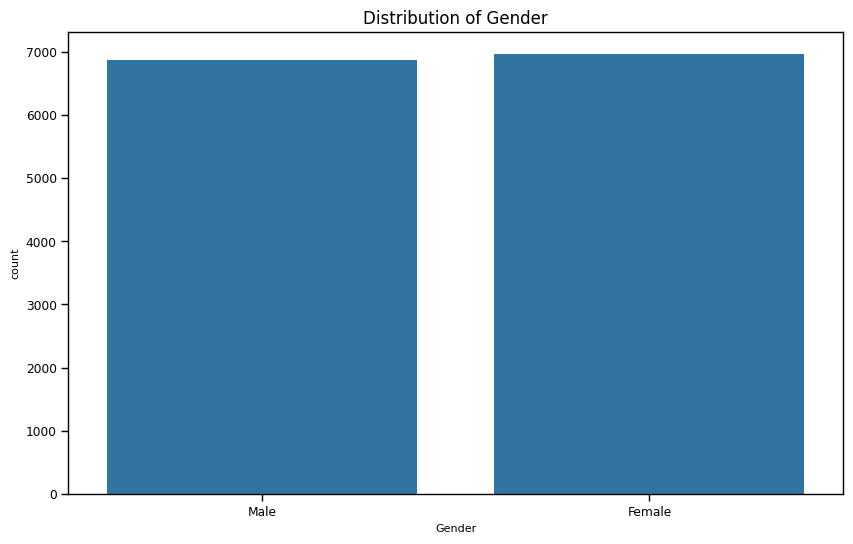

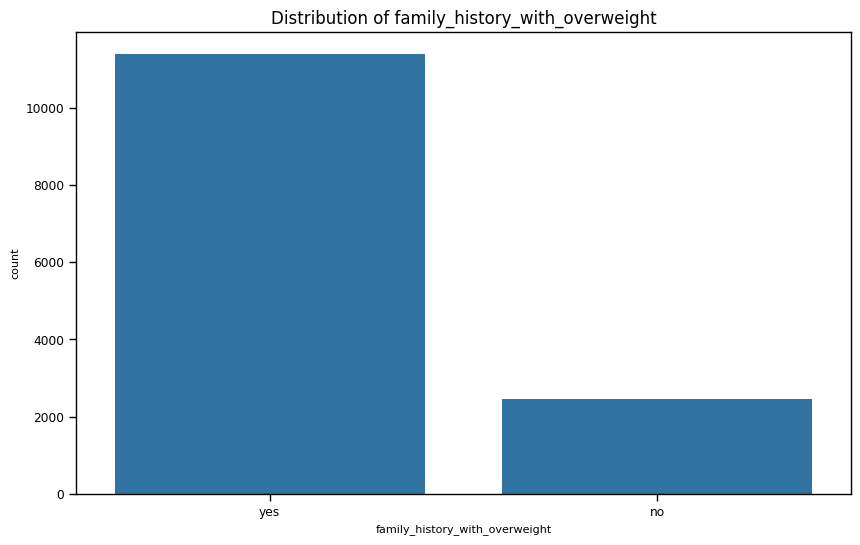

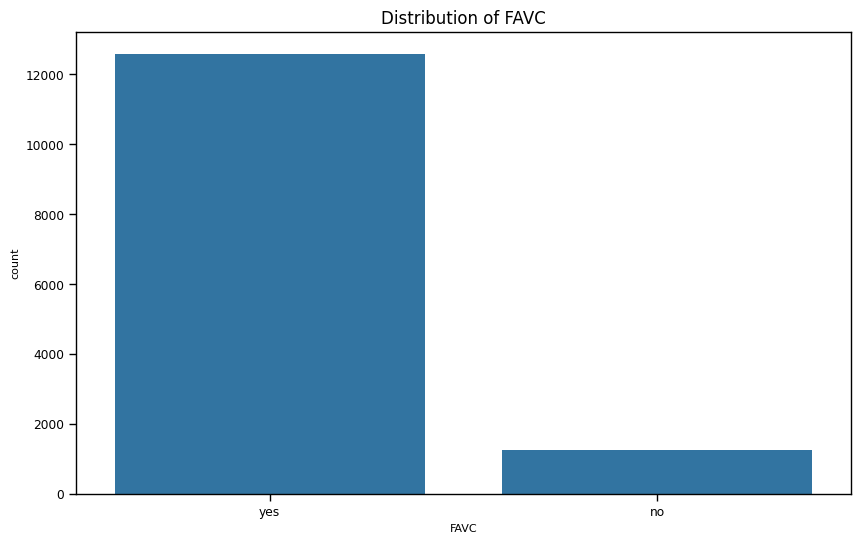

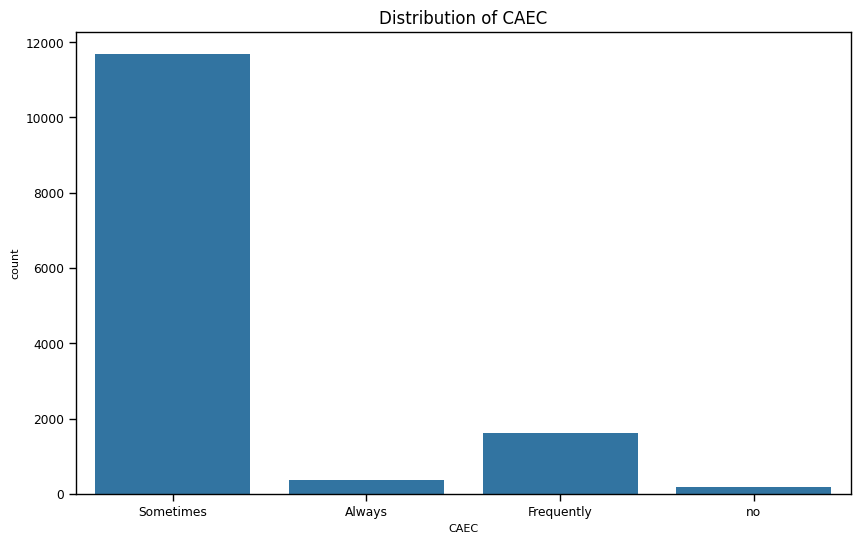

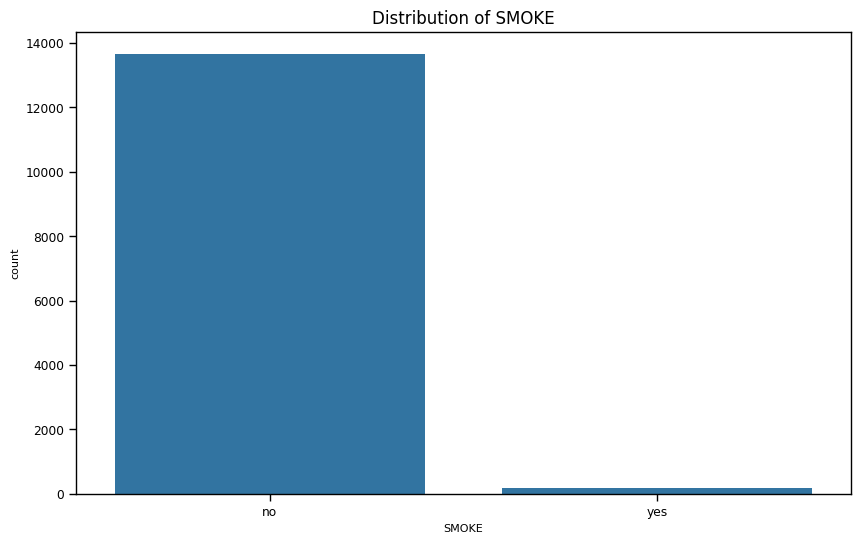

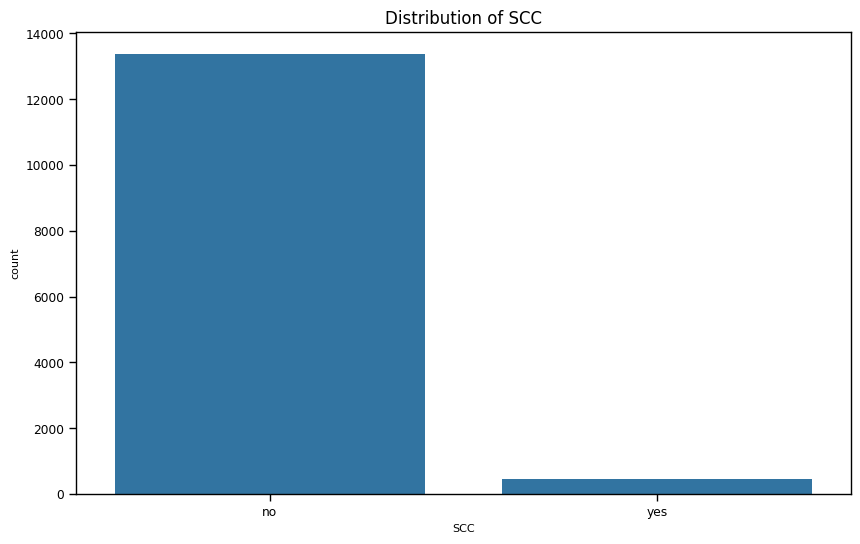

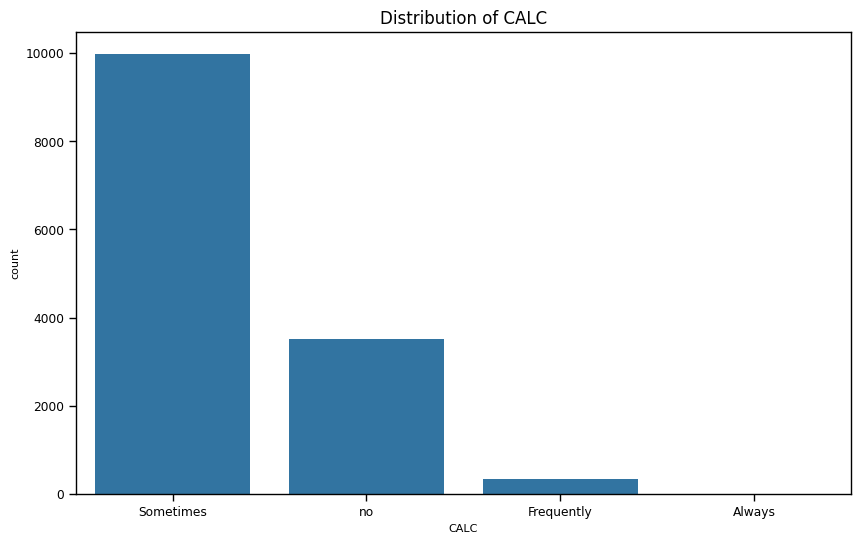

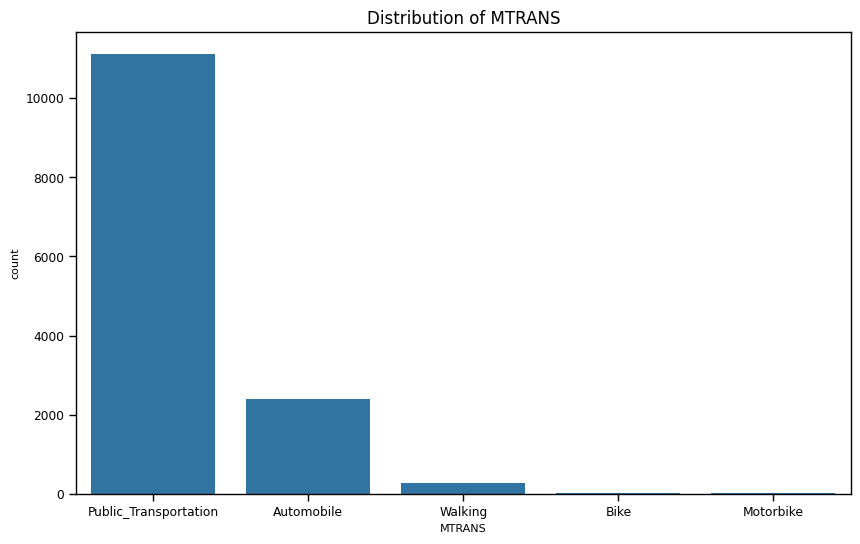

In [78]:
plot_data_overview(test_df)

### Preprocessing

In [11]:
# Data cleaning
if 'id' in train_df.columns:
    del train_df['id']

# Define classes
class_labels = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]

# Target feature name
target_column = 'NObeyesdad'

# Order target variable
train_df[target_column] = pd.Categorical(
    train_df[target_column], 
    categories=class_labels,
    ordered=True
)

In [12]:
# Define features for encoding
ordinal_cols = {
    'CAEC': ['no', 'Sometimes', 'Frequently', 'Always'],
    'CALC': ['no', 'Sometimes', 'Frequently', 'Always']
}
one_hot_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

In [14]:
# Val data used for LightGBM model
X_train, X_val, y_train, y_val = [
    df.reset_index(drop=True)
    for df in train_test_split(
        train_df.loc[:, train_df.columns != target_column],
        train_df[target_column],
        test_size=0.1,
        random_state=42
    )
]                                    

In [45]:
# Encoding
X_train_enc = encode_input_features(X_train, ordinal_cols, one_hot_cols)
X_val_enc = encode_input_features(X_val, ordinal_cols, one_hot_cols)
y_train_enc, label_encoder = label_encode(y_train)
y_val_enc, label_encoder = label_encode(y_test)

### LightGBM

In [40]:
# Create datasets for LightGBM model
lgb_train = lgb.Dataset(data=X_train_enc, label=y_train_enc)
lgb_val = lgb.Dataset(data=X_val_enc, label=y_val_enc, reference=lgb_train)

#### Base model

In [25]:
# Define hyperparameters
lgb_params = {
    "objective" : "multiclass",
    'num_class': 7,
    "metric" : "multi_error",
    'num_leaves': 8,
    'max_depth': 4,
    'num_iterations': 1000,
    'early_stopping_rounds': 200,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'nthread': -1,
    "verbosity" : 1
}

In [26]:
model_lgb = lgb.train(
    lgb_params, 
    lgb_train,
    valid_sets=[lgb_train, lgb_val]
)

C:\Users\Shashank\AppData\Local\pypoetry\Cache\virtualenvs\multiclass-classification-_rGd4WqF-py3.8\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 18682, number of used features: 25
[LightGBM] [Info] Start training from score -2.108662
[LightGBM] [Info] Start training from score -1.915233
[LightGBM] [Info] Start training from score -1.953001
[LightGBM] [Info] Start training from score -1.859064
[LightGBM] [Info] Start training from score -1.635028
[LightGBM] [Info] Start training from score -2.146860
[LightGBM] [Info] Start training from score -2.105141
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's multi_error: 0.0871962	valid_1's multi_error: 0.0881503


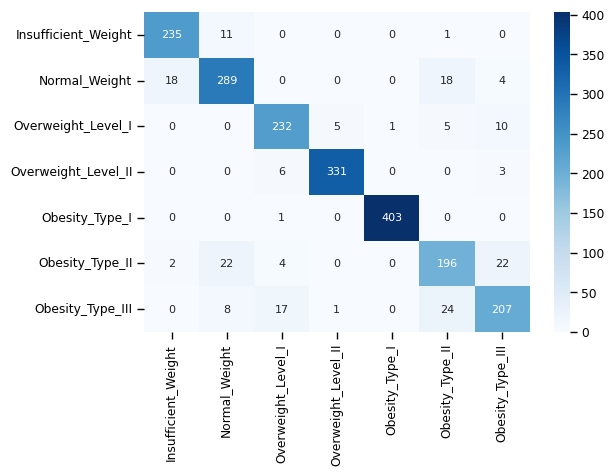

{'accuracy': 0.911849710982659, 'f1_score': 0.911849710982659}


In [38]:
test_score = evaluate_model(model_lgb, X_val_enc, y_val_enc, class_labels, is_ligthgbm=True)
print(test_score)

In [55]:
save_test_prediction_result(model, test_df, ordinal_cols, one_hot_cols, target_column, label_encoder, is_ligthgbm=True)